## Setup

In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os

from sklearn.utils import shuffle
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_gamma
from skimage.transform import rotate, warp, ProjectiveTransform, SimilarityTransform, matrix_transform
from skimage import img_as_ubyte, img_as_float
from sklearn.model_selection import train_test_split

## Load Data

In [2]:
data_paths = [ r"D:\recordings\data\data", r"D:\recordings\r1", r'D:\recordings\r4' ] #, r"D:\recordings\r2", r"D:\recordings\r3" ]

def read_log():
    lines = []
    
    for data_path in data_paths:
        with open(os.path.join(data_path, r'driving_log.csv')) as csvfile:
            reader = csv.reader(csvfile)
            next(reader, None) # skip headers
            
            for line in reader:    
                for i in range(3):
                    line[i] = os.path.join(data_path, 'IMG', os.path.basename(line[i]))
                
                lines.append(line)
            
    return lines

In [3]:
data_lines = read_log()
print(data_lines[0:3])

[['D:\\recordings\\data\\data\\IMG\\center_2016_12_01_13_30_48_287.jpg', 'D:\\recordings\\data\\data\\IMG\\left_2016_12_01_13_30_48_287.jpg', 'D:\\recordings\\data\\data\\IMG\\right_2016_12_01_13_30_48_287.jpg', ' 0', ' 0', ' 0', ' 22.14829'], ['D:\\recordings\\data\\data\\IMG\\center_2016_12_01_13_30_48_404.jpg', 'D:\\recordings\\data\\data\\IMG\\left_2016_12_01_13_30_48_404.jpg', 'D:\\recordings\\data\\data\\IMG\\right_2016_12_01_13_30_48_404.jpg', ' 0', ' 0', ' 0', ' 21.87963'], ['D:\\recordings\\data\\data\\IMG\\center_2016_12_01_13_31_12_937.jpg', 'D:\\recordings\\data\\data\\IMG\\left_2016_12_01_13_31_12_937.jpg', 'D:\\recordings\\data\\data\\IMG\\right_2016_12_01_13_31_12_937.jpg', ' 0', ' 0', ' 0', ' 1.453011']]


In [4]:
import math

def process_lines(lines):
    images = []
    measurements = []

    for line in lines[1:]:
        images.append([line[0], line[1], line[2]])
        
        measurement = float(line[3])
        measurements.append(measurement)
        
    images = np.array(images)
    measurements = np.array(measurements)
    
    return images, measurements

X_data, y_meas = process_lines(data_lines)

print('total number of samples')
print(X_data.shape)

total number of samples
(23094, 3)


In [5]:
def show_all_images(X):
    num = len(X)
    
    plt.figure(figsize=(num*5, 5))
    
    key = int(100 + 10*num + 1)
    
    for index in range(num):
        image = X[index].squeeze()
        plt.subplot(key)
        plt.imshow(image)
        key += 1
    
    plt.show()
    
def showrandom(X, num=1, ind = None):
    if ind == None:
        ind = np.random.randint(0, len(X), num)
        
    show_all_images(X[ind])
    
def show_all_images_gray(X):
    num = len(X)
    
    plt.figure(figsize=(num*5, 5))
    
    key = int(100 + 10*num + 1)
    
    for index in range(num):
        image = X[index].squeeze()
        plt.subplot(key)
        plt.imshow(image, cmap="gray")
        key += 1
    
    plt.show()
    
def showrandom_gray(X, num=1, ind = None):
    if ind == None:
        ind = np.random.randint(0, len(X), num)
        
    show_all_images_gray(X[ind])

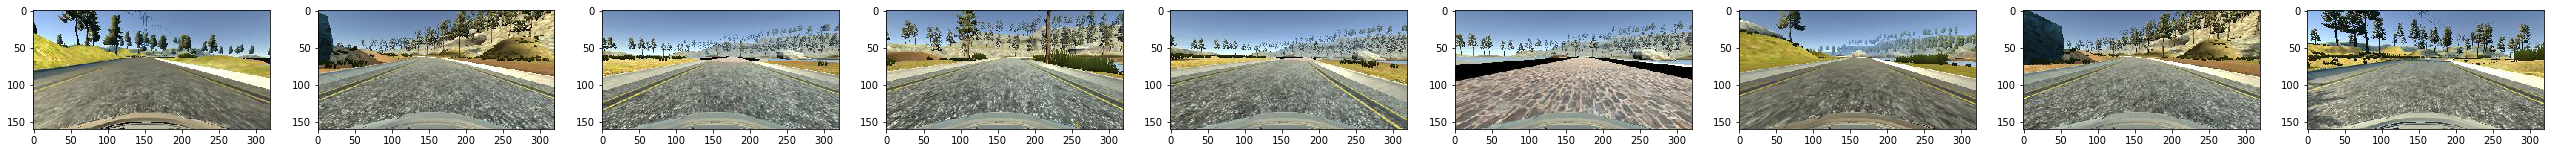

In [6]:
def load_single(img_path):
    return np.array(img_as_float(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)), dtype=np.float32)

def load_all(img_paths):
    images = []
    
    for img_path in img_paths:
        images.append(img_as_float(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)))
        
    return np.array(images, dtype=np.float32)

def load_and_show_images(imgs):
    num = len(imgs)
    
    plt.figure(figsize=(num*5, 5))
    
    key = int(100 + 10*num + 1)
    
    for index in range(num):
        image = load_single(imgs[index])
        plt.subplot(key)
        plt.imshow(image)
        key += 1
    
    plt.show()

def load_and_show_random_images(imgs,  num=1, ind = None):
    if ind == None:
        ind = np.random.randint(0, len(imgs), num)
        
    load_and_show_images(imgs[ind])
    

load_and_show_random_images(X_data[:, 0], 9)

## Data Statistics

Original distribution of features / labels


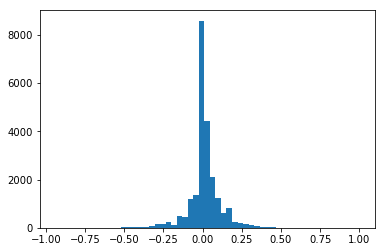

-0.9426954
1.0


In [7]:
print("Original distribution of features / labels")
plt.hist(y_meas, 55)
plt.show()
print(np.min(y_meas))
print(np.max(y_meas))

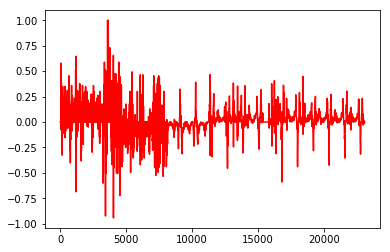

In [8]:
plt.plot(y_meas, 'r')
plt.show()

## Filtering

In [9]:
def filter_data(X, y):
    bins = 1200
    max_number = 50
    
    X_out = []
    y_out = []
    
    start = 0
    
    for end in np.linspace(0, 1.2, bins):
        ind = [i for i in range(len(X)) if abs(y[i]) >= start and abs(y[i]) < end]
        
        if len(ind) > max_number:
            ind = np.random.choice(ind, max_number)
        
        X_out.append(X[ind])
        y_out.append(y[ind])
        
        start = end
        
    return np.concatenate(X_out, axis=0), np.concatenate(y_out, axis=0)
        
X_f, y_f = filter_data(X_data, y_meas)

Filtered distribution of features / labels
(5326, 3)
(5326,)


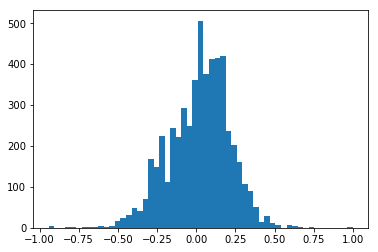

In [10]:
print("Filtered distribution of features / labels")
print(X_f.shape)
print(y_f.shape)
plt.hist(y_f, 55)
plt.show()

(15978,)
(15978,)


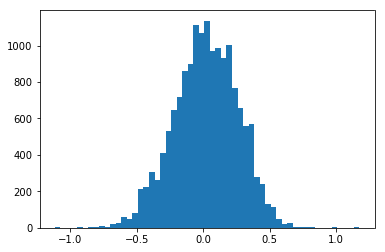

In [11]:
def use_side_cameras(X, y):
    X_side = np.array(X[:, 0], copy=True)
    X_side = np.append(X_side, X[:, 1], axis = 0)
    X_side = np.append(X_side, X[:, 2], axis = 0)

    y_side = np.array(y, copy=True)
    y_side = np.append(y_side, y + 10. / 180. * math.pi, axis = 0)
    y_side = np.append(y_side, y - 10. / 180. * math.pi, axis = 0)
    
    return X_side, y_side


X_side, y_side = use_side_cameras(X_f, y_f)

print(X_side.shape)
print(y_side.shape)
plt.hist(y_side, 55)
plt.show()

In [ ]:
import gc

gc.collect()

### Save filtered list to file

In [ ]:
import pickle

pickle.dump( (X_f, y_f), open('filtered.p', 'wb'))

### Load filtered list from file

In [ ]:
import pickle


with open('filtered.p', 'rb') as pkl_file:
    X_f, y_f = pickle.load(pkl_file)

print("Filtered distribution of features / labels")
print(X_f.shape)
print(y_f.shape)
plt.hist(y_f, 55)
plt.show()

## Data Augmentation

In [12]:
def apply_random_flip_single(X, y):
    flip = np.random.randint(-1, 2)
    
    if flip < 0:
        X = X[:, ::-1, :]
        y = -y
            
    return X, y

In [13]:
def apply_random_brightness_single(X):
    gamma = np.random.uniform(0.5, 1.5)
    
    return adjust_gamma(X, gamma)

In [14]:
def apply_random_shifting_single(X, y, max_delta = 80, ratio = 0.001):
    delta = np.random.uniform(-max_delta, max_delta)
        
    offsetx = delta
    offsety = 0
    
    tf_shift = SimilarityTransform(translation=[offsetx, offsety])
    
    X_copy = warp(X, tf_shift)
    y += -ratio*delta
    
    return X_copy, y

In [15]:
def apply_random_shadow_single(X):
    img_width = 320
    img_height = 160
    
    alpha = np.random.uniform(0.1, 0.85)
    x = np.random.uniform(0, img_width, 2)
    width = np.random.uniform(80, 240, 2)
    
    points = np.array([[x[0],0], [x[1],img_height], [min(img_width,x[1] + width[1]),img_height], [min(x[0]+width[0],img_width),0]], np.int32)
    points = points.reshape((-1,1,2))
    shadow_color = (0,0,0)
    
    X_copy = cv2.cvtColor(X, cv2.COLOR_RGB2RGBA)
    X_overlay = np.array(X_copy, copy=True)
    X_overlay = cv2.fillPoly(X_overlay, [points], shadow_color)
    X_temp = np.empty(X_copy.shape, dtype=np.float32)
    
    cv2.addWeighted(X_copy, alpha, X_overlay, 1.-alpha, 0, X_temp)
    
    return cv2.cvtColor(X_temp, cv2.COLOR_RGBA2RGB)

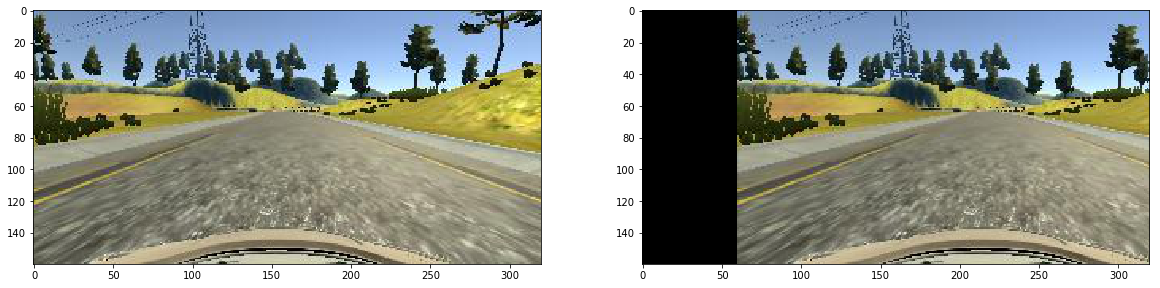

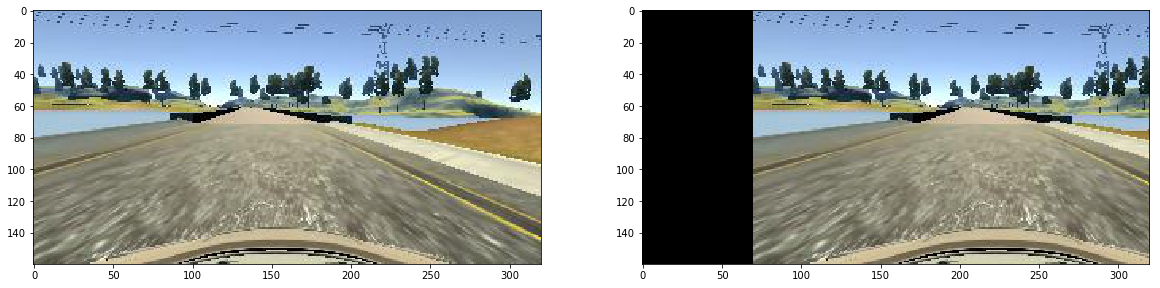

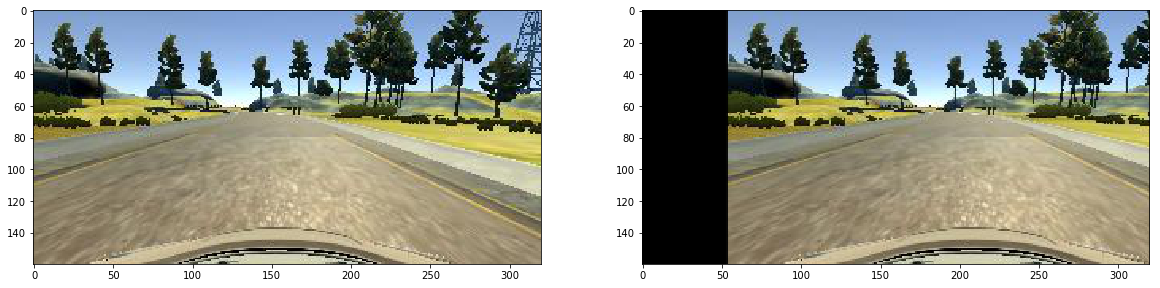

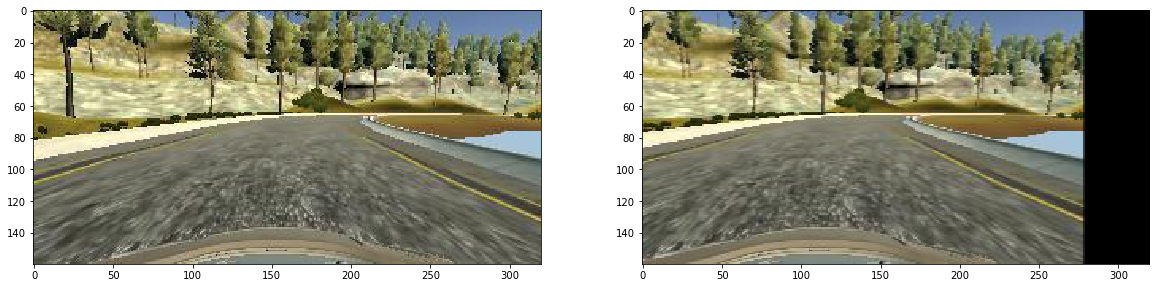

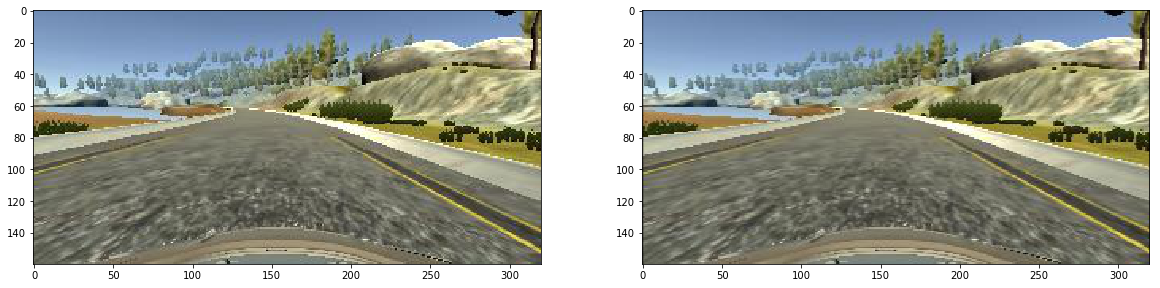

In [16]:
def shift_single_demo():
    X_img = load_single(X_f[np.random.randint(len(X_f)), 0])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(X_img)
    
    X_shift, y_shift = apply_random_shifting_single(X_img, 0)
    
    plt.subplot(122)
    plt.imshow(X_shift)
    plt.show()
    
for i in range(5):
    shift_single_demo()

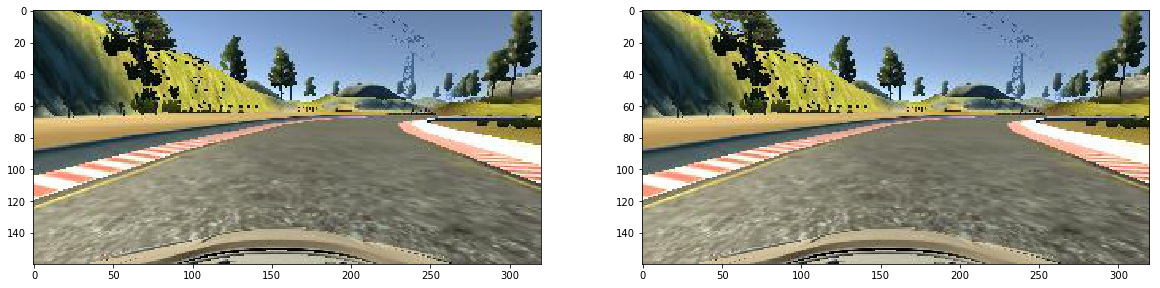

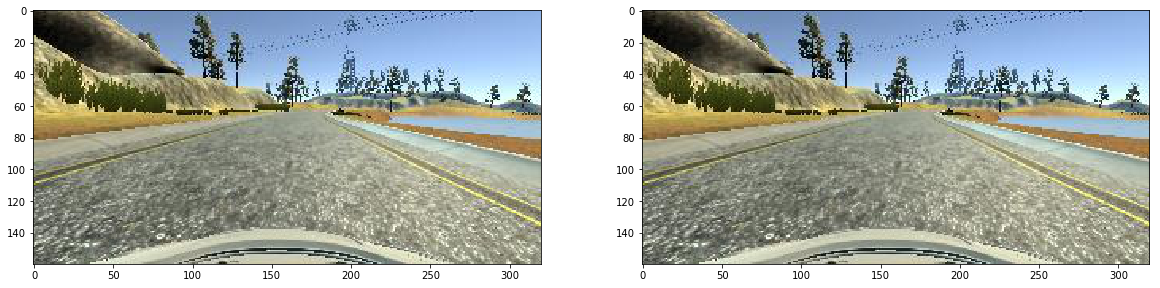

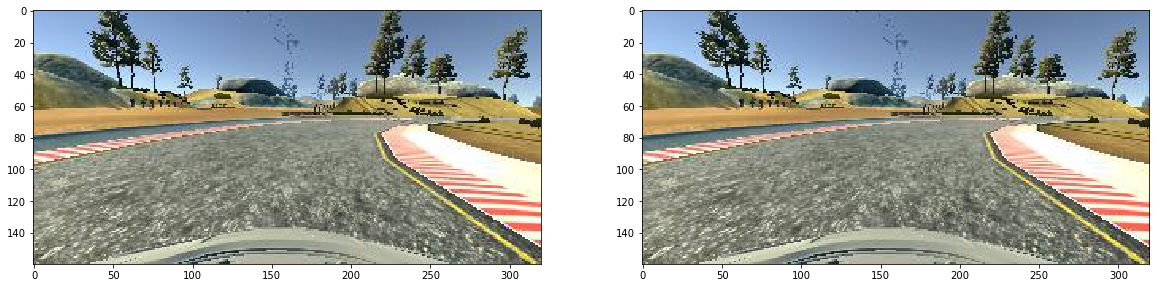

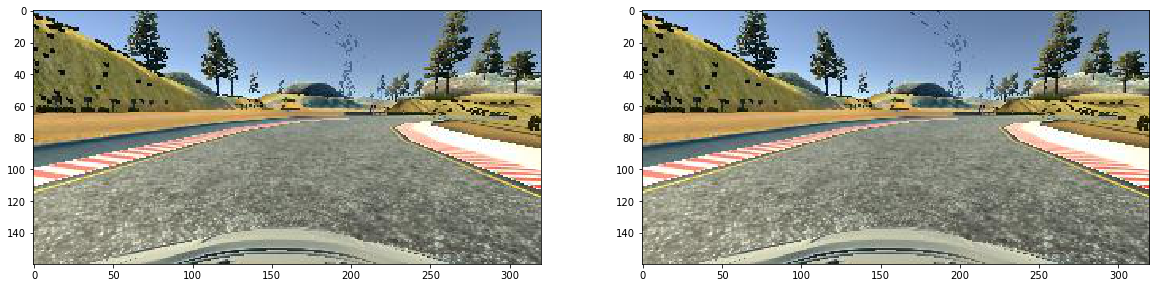

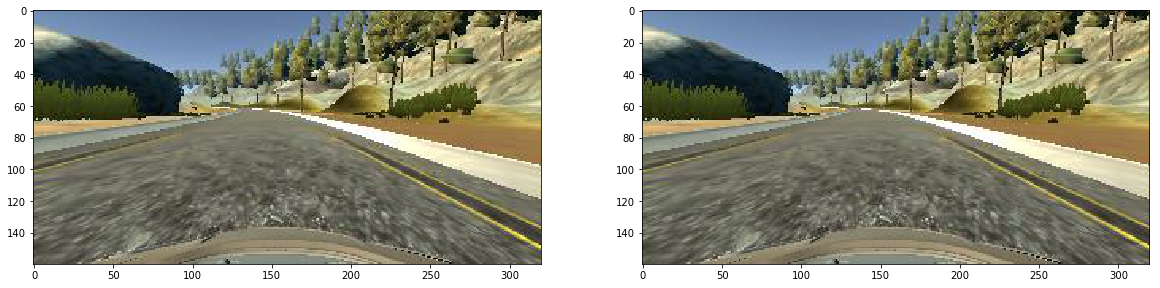

In [17]:
def flip_demo():
    X_img = load_single(X_f[np.random.randint(len(X_f)), 0])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(X_img)
    
    X_flip, y_flip = apply_random_flip_single(X_img, 1)
    
    plt.subplot(122)
    plt.imshow(X_flip)
    plt.show()
    
for i in range(5):
    flip_demo()

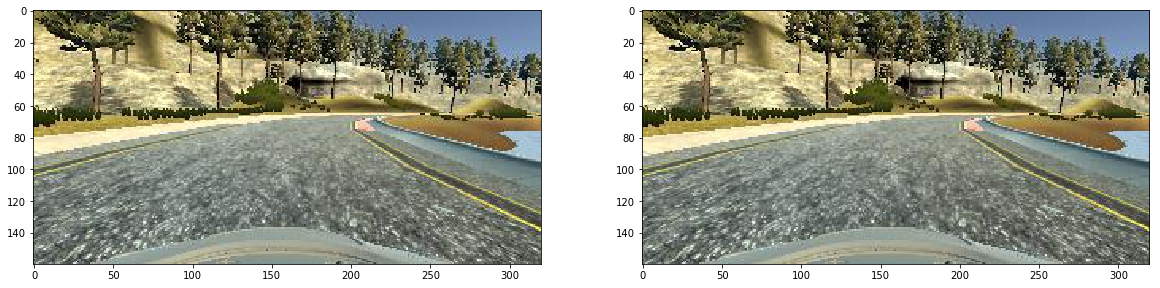

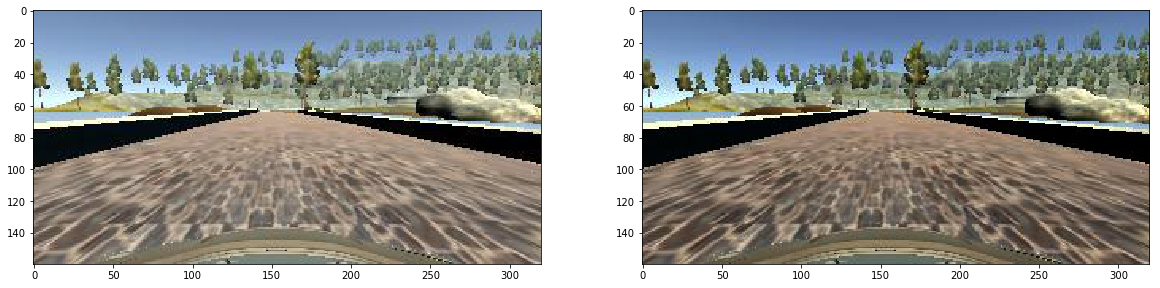

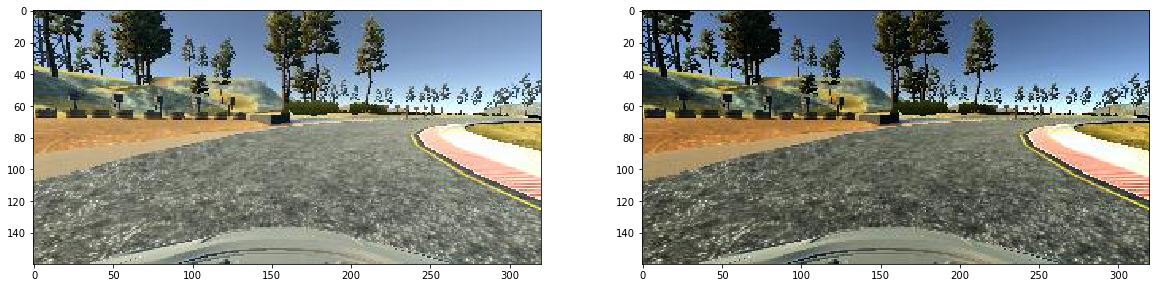

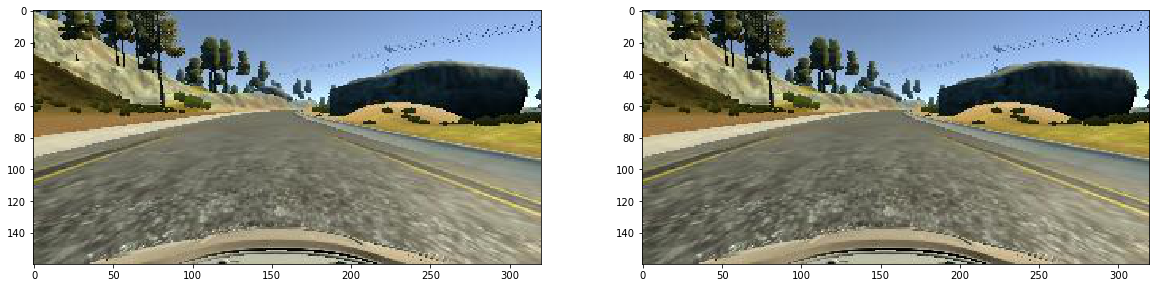

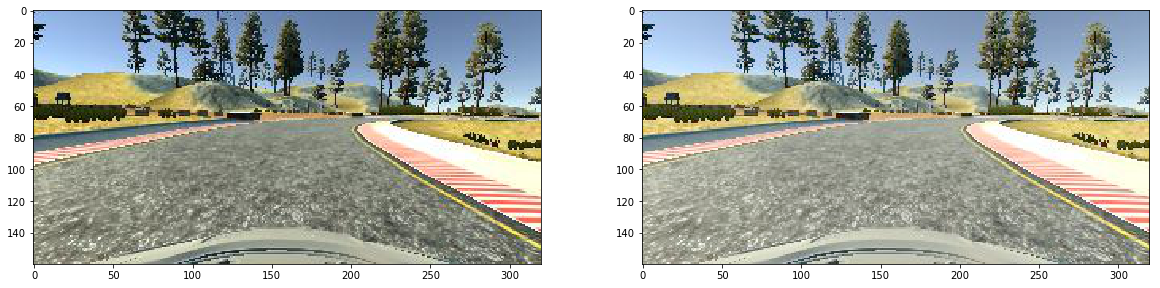

In [18]:
def shift_brightness_demo():
    X_img = load_single(X_f[np.random.randint(len(X_f)), 0])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(X_img)
    
    X_bright = apply_random_brightness_single(X_img)
    
    plt.subplot(122)
    plt.imshow(X_bright)
    plt.show()

for i in range(5):
    shift_brightness_demo()

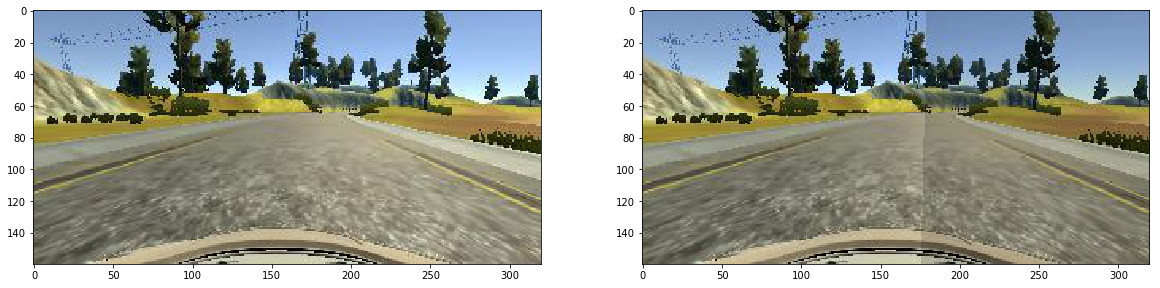

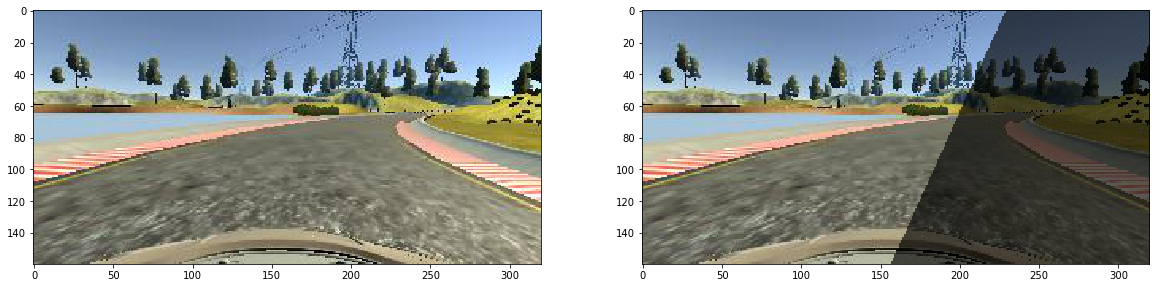

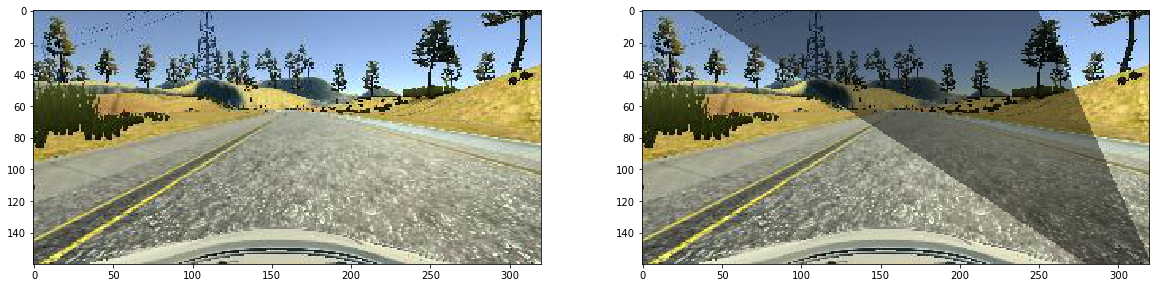

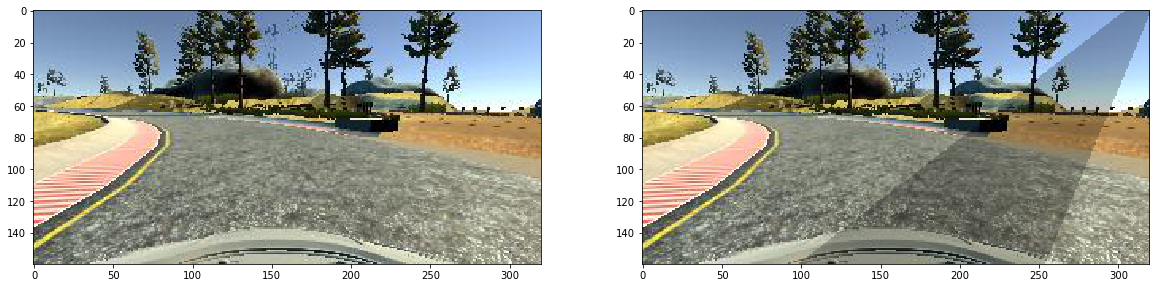

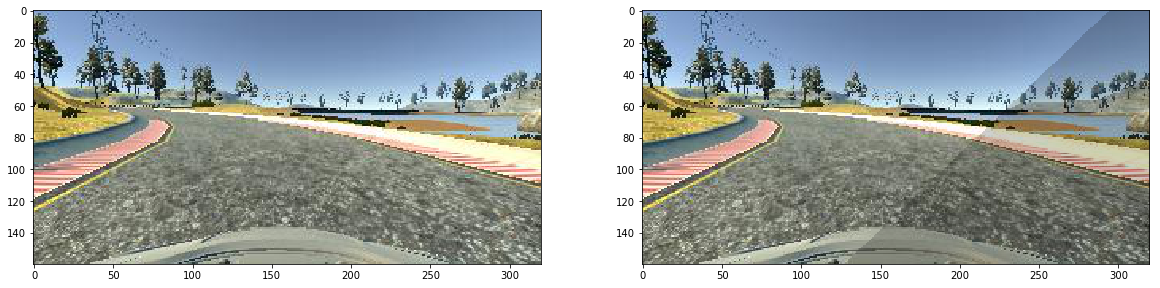

In [19]:
def shadow_demo():
    X_img = load_single(X_f[np.random.randint(len(X_f)), 0])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(X_img)
    
    X_shadow = apply_random_shadow_single(X_img)
        
    plt.subplot(122)
    plt.imshow(X_shadow)
    plt.show()
    
for i in range(5):
    shadow_demo()

In [20]:
def generate_samples(X, y, augment=False):
    # apply filtering
    X, y = filter_data(X, y)
        
    if augment:    
        # use side data
        X, y = use_side_cameras(X, y)
    else:
        X = X[:, 0]
    
    n_samples = len(X)
    batch_size = 128
    ind = np.random.permutation(n_samples)
    count = 0
    
    #print('samples: ', n_samples, ' bs: ', batch_size, X.shape, y.shape)
    
    while True:
        for batch in range(0, n_samples, batch_size):
            batch_ind = ind[batch:(batch+batch_size)]
            
            X_b = load_all(X[batch_ind])[:, 50:130, :, :]
            y_b = np.array(y[batch_ind], copy=True)
            
            if augment:
                for i in range(len(batch_ind)):
                    X_b[i], y_b[i] = apply_random_flip_single(X_b[i], y_b[i])
                    X_b[i] = apply_random_brightness_single(X_b[i])
                    X_b[i], y_b[i] = apply_random_shifting_single(X_b[i], y_b[i])
                    X_b[i] = apply_random_shadow_single(X_b[i])
                    
            for i in range(len(batch_ind)):
                X_b[i] = equalize_adapthist(X_b[i])
                
            count += len(batch_ind)
                    
            yield (X_b, y_b)

C:\Users\janm\AppData\Local\Continuum\Miniconda3\envs\jangpu\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


(30, 80, 320, 3)


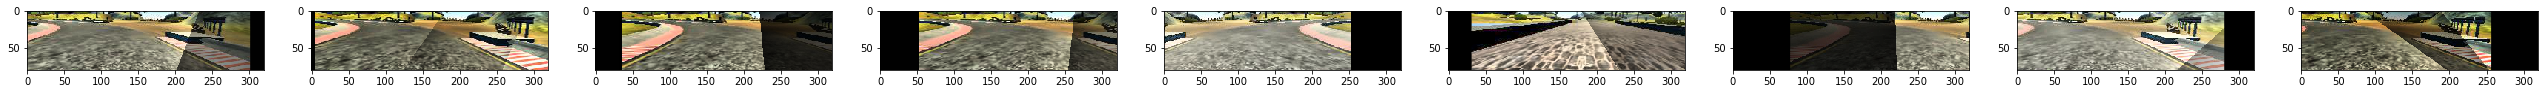

Filtered distribution of features / labels


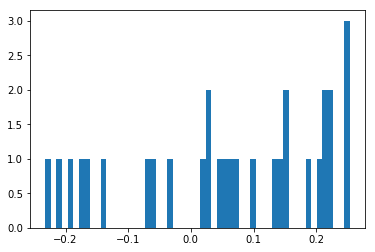

In [21]:
import itertools

Z_test = list(itertools.islice(generate_samples(X_data[0:10], y_meas[0:10], True), 9))
X_aug_test, y_aug_test = Z_test[0][0], Z_test[0][1]

print(X_aug_test.shape)

showrandom_gray(X_aug_test, 9)

print("Filtered distribution of features / labels")
plt.hist(y_aug_test, 55)
plt.show()

In [22]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Activation, Lambda, Cropping2D
from keras.optimizers import Adam
from keras.layers import BatchNormalization,Input
from keras import regularizers
from keras.backend import tf as ktf

Using TensorFlow backend.


In [23]:
def get_model():
    model = Sequential()
    
    reg=regularizers.l2(0.0001)
    
    #model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    
    #model.add(Conv2D(24, (5, 5), padding='valid', activation='relu', strides=(2,2)))
    #model.add(Conv2D(36, (5, 5), padding='valid', activation='relu', strides=(2,2)))
    #model.add(Conv2D(48, (5, 5), padding='valid', activation='relu', strides=(2,2)))
    #model.add(Conv2D(64, (3, 3), padding='valid', activation='relu', strides=(1,1)))
    #model.add(Conv2D(64, (3, 3), padding='valid', activation='relu', strides=(1,1)))
    
    model.add(Conv2D(32, (5,5), activation='relu', strides=(1,1), input_shape=(80,320,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (5,5), activation='relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (5,5), activation='relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    
    model.add(Dense(1000, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='relu',kernel_regularizer=reg))
    model.add(Dropout(0.25))
    #model.add(Dense(20, activation='relu'))
    #model.add(Dense(1, activation='tanh'))
    model.add(Dense(1))
    
    #model.add(Dense(1164, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(50, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(1, activation='tanh'))
    
    adam = Adam(lr=0.0001)
    
    model.compile(loss='mse', optimizer=adam, metrics=['mse','accuracy'])
    
    return model

In [ ]:
def get_nvidia_model():
    model = Sequential()
    
    model.add(Lambda(lambda image: ktf.image.resize_images(image, (66, 200)),input_shape=(80,320,3)))
    
    model.add(BatchNormalization(epsilon=0.001, axis=1))

    model.add(Conv2D(24,(5,5),padding='valid', activation='relu', strides=(2,2)))
    model.add(Conv2D(36,(5,5),padding='valid', activation='relu', strides=(2,2)))
    model.add(Conv2D(48,(5,5),padding='valid', activation='relu', strides=(2,2)))
    model.add(Conv2D(64,(3,3),padding='valid', activation='relu', strides=(1,1)))
    model.add(Conv2D(64,(3,3),padding='valid', activation='relu', strides=(1,1)))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    adam = Adam(lr=0.0001)
    
    model.compile(loss='mse', optimizer=adam, metrics=['mse','accuracy'])
    
    return model

In [24]:
#model = get_nvidia_model()
model = get_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 76, 316, 32)       2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 158, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 154, 64)       51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 77, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 73, 128)       204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 36, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 27648)             0         
__________

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_meas, test_size=.2)

model.fit_generator(generate_samples(X_train, y_train, True), 
                    steps_per_epoch=int(0.8*len(X_side))/128,
                    epochs=50,
                    validation_data=generate_samples(X_val, y_val, False),
                    validation_steps = int(0.2*len(X_f))/128)

Epoch 1/50


C:\Users\janm\AppData\Local\Continuum\Miniconda3\envs\jangpu\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


100/99 [==============================] - 366s - loss: 0.1988 - mean_squared_error: 0.0531 - acc: 0.0000e+00 - val_loss: 0.1271 - val_mean_squared_error: 0.0163 - val_acc: 0.0095
Epoch 2/50
100/99 [==============================] - 304s - loss: 0.1321 - mean_squared_error: 0.0353 - acc: 0.0000e+00 - val_loss: 0.1000 - val_mean_squared_error: 0.0140 - val_acc: 0.0321
Epoch 3/50
100/99 [==============================] - 296s - loss: 0.1050 - mean_squared_error: 0.0265 - acc: 0.0000e+00 - val_loss: 0.0835 - val_mean_squared_error: 0.0119 - val_acc: 0.0122
Epoch 4/50
86/99 [========================>.....] - ETA: 37s - loss: 0.0911 - mean_squared_error: 0.0243 - acc: 0.0000e+00

In [ ]:
model.save('model-noob-2.h5')

In [ ]:
model.summary()

In [ ]:
def preprocess_image(X):
    return equalize_adapthist(img_as_float(X[50:130, :, :]))

In [ ]:
def test_pred():
    ind = range(100)
    
    y_pred = []
    y_actual = y_val[ind]
    
    for i in ind:
        X_img = load_single(X_val[i])
        
        plt.imshow(X_img)
        plt.show()
        
        X_prep = preprocess_image(X_img)
        
        y = float(model.predict(X_prep[None, :, :, :], batch_size=1))
        
        print(y, y_val[i])
        
        y_pred.append(y)
        
    plt.plot(y_pred)
    plt.show()
    plt.plot(y_actual)
    plt.show()
       
        
test_pred()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
model = load_model('model-z2.h5', custom_objects={"ktf": ktf})

In [ ]:
import os
from PIL import Image


def predict_image(path):
    image = Image.open(path)
    
    image_array = np.asarray(image)
    
    plt.imshow(image_array)
    plt.show()
    
    image_array = image_array[50:140, :, :]
    
    plt.imshow(image_array)
    plt.show()
    
    img_opt = equalize_adapthist(img_as_float(image_array))
    
    plt.imshow(img_opt)
    plt.show()

    steering_angle = float(model.predict(img_opt[None, :, :, :], batch_size=1))
        
    print(steering_angle)
    
img_dir = r"D:\out\img2"
files = os.listdir(img_dir)
                   
for file in files[0:10]:
    print(file)
    predict_image(os.path.join(img_dir, file))